# Import the needed packages

In [1]:
import glob
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL

# Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Understanding the data

In [3]:
PRINT_FILE_X_DIR = 5
# exploring situation on extracted files : directories with images and their sizes
def explore_image_on_directory(data_dir):
    directories = {}
    directory_files = os.listdir(data_dir)
    for d in directory_files:
      class_dir = os.path.join(data_dir, d)
      if os.path.isdir(class_dir):
        directories[d] = []
        files = os.listdir(class_dir)
        for f in files:
          file_path = os.path.join(class_dir,f)
          if os.path.isfile(file_path) and os.path.getsize(file_path):
            directories[d].append(os.path.join(class_dir,f))
    # print analysis directories
    tot = 0
    for c in directories.keys():
      print(c, len(directories[c]))
      tot += len(directories[c])
      for f in directories[c][:PRINT_FILE_X_DIR]:
        image = PIL.Image.open(f)
        print(c, f, image.size)
    print(f"TOT:{tot}")
explore_image_on_directory("/content/gdrive/MyDrive/Catvsdog_Kaggle/")

test1 12500
test1 /content/gdrive/MyDrive/Catvsdog_Kaggle/test1/11483.jpg (246, 335)
test1 /content/gdrive/MyDrive/Catvsdog_Kaggle/test1/11499.jpg (319, 240)
test1 /content/gdrive/MyDrive/Catvsdog_Kaggle/test1/11504.jpg (359, 359)
test1 /content/gdrive/MyDrive/Catvsdog_Kaggle/test1/11523.jpg (194, 260)
test1 /content/gdrive/MyDrive/Catvsdog_Kaggle/test1/11520.jpg (374, 500)
train 25000
train /content/gdrive/MyDrive/Catvsdog_Kaggle/train/cat.9115.jpg (499, 400)
train /content/gdrive/MyDrive/Catvsdog_Kaggle/train/cat.9068.jpg (500, 465)
train /content/gdrive/MyDrive/Catvsdog_Kaggle/train/cat.9108.jpg (499, 333)
train /content/gdrive/MyDrive/Catvsdog_Kaggle/train/cat.9089.jpg (404, 499)
train /content/gdrive/MyDrive/Catvsdog_Kaggle/train/cat.9117.jpg (375, 499)
TOT:37500


# Data Preprocessing

In [4]:
WORKING_DIR="/content/gdrive/MyDrive/Catvsdog_Kaggle"
TRAIN_PATH = os.path.join(WORKING_DIR, 'train')
TEST_PATH = os.path.join(WORKING_DIR, 'test1')

In [5]:
# creating Dataframe for training: category is on filename
train_filenames = os.listdir(TRAIN_PATH)
train_categories = [ f.split('.')[0] for f in train_filenames ]

train_df = pd.DataFrame({
    'image': train_filenames,
    'class': train_categories})

train_df.tail()

,image,class
24995,dog.1086.jpg,dog
24996,dog.10920.jpg,dog
24997,dog.10933.jpg,dog
24998,dog.10927.jpg,dog
24999,dog.10915.jpg,dog


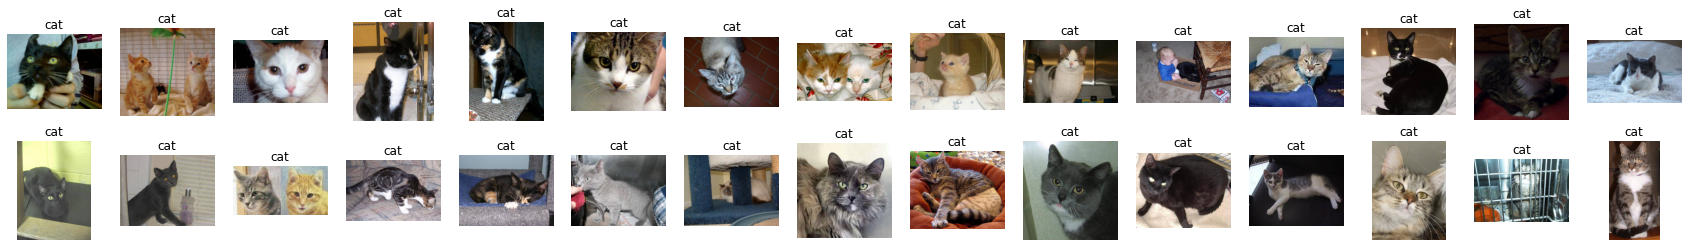

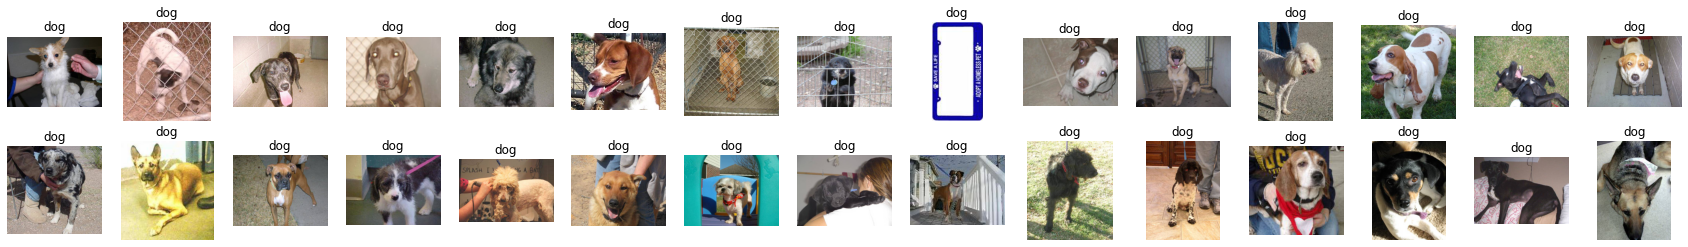

In [6]:
# show the first images of cats and dogs
def show_images(df, images_path):
    fig, axs = plt.subplots(2, 15, figsize=(30, 4))
    for i in range(30):
        ax = axs[i // 15, i % 15]
        ax.set_axis_off()
        if i<len(df['image']):            
            image = PIL.Image.open(os.path.join(images_path, df['image'].iloc[i]))
            ax.set_title(df['class'].iloc[i])
            ax.imshow(image)
        
cats_df = train_df.loc[train_df['class'] == 'cat']
dogs_df = train_df.loc[train_df['class'] == 'dog']
show_images(cats_df, TRAIN_PATH)
show_images(dogs_df, TRAIN_PATH)

In [7]:
BATCH_SIZE = 150
IMG_WIDTH = 160
IMG_HEIGHT = 160

In [8]:
import tensorflow as tf
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
# rescaling on MobileV2 with preprocess_input
# Add our data-augmentation parameters to ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                   )

In [9]:
# rescaling on MobileV2 with preprocess_input
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(validation_split=0.2)

# Flow training images in batches of BATCH_SIZE using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=TRAIN_PATH,
                                                    x_col="image",
                                                    y_col="class",
                                                    subset="training",
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary', 
                                                    target_size = (IMG_WIDTH, IMG_HEIGHT)
                                                   )

Found 20000 validated image filenames belonging to 2 classes.


In [10]:
# Flow validation images in batches of BATCH_SIZE using test_datagen generator
validation_generator =  test_datagen.flow_from_dataframe(train_df,
                                                         directory=TRAIN_PATH,
                                                         x_col="image",
                                                         y_col="class",
                                                         subset="validation",
                                                         batch_size = BATCH_SIZE,
                                                         class_mode = 'binary', 
                                                         target_size = (IMG_WIDTH, IMG_HEIGHT)
                                                        )

Found 5000 validated image filenames belonging to 2 classes.


# Model

Transfer learning is used for this purpose. The model that is selected here as the baseline model is mobilenet. The mobile net model is usually used for models with simple classification. So mobilenet is used here. Imagenet weights are used for the model.

In [11]:
# Create the base model from the pre-trained model MobileNet V2 (feature extraction without TOP layers)
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                                               include_top=False,
                                               weights='imagenet')


base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
________________

The top layer ofthe model has a average pooling llayer and a dense layer for getting the result

In [12]:
# Our model definition with our Dropout and Dense TOP layers
inputs = tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

158

# Training

In [15]:
# training
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    batch_size=BATCH_SIZE)

Epoch 1/10
134/134 [==============================] - 11725s 87s/step - loss: 0.1245 - accuracy: 0.9458 - val_loss: 0.1083 - val_accuracy: 0.9672
Epoch 2/10
134/134 [==============================] - 251s 2s/step - loss: 0.0709 - accuracy: 0.9715 - val_loss: 0.0188 - val_accuracy: 0.9950
Epoch 3/10
134/134 [==============================] - 248s 2s/step - loss: 0.0679 - accuracy: 0.9722 - val_loss: 0.0552 - val_accuracy: 0.9866
Epoch 4/10
134/134 [==============================] - 249s 2s/step - loss: 0.0535 - accuracy: 0.9790 - val_loss: 0.0945 - val_accuracy: 0.9704
Epoch 5/10
134/134 [==============================] - 248s 2s/step - loss: 0.0515 - accuracy: 0.9801 - val_loss: 0.0473 - val_accuracy: 0.9874
Epoch 6/10
134/134 [==============================] - 247s 2s/step - loss: 0.0495 - accuracy: 0.9798 - val_loss: 0.0519 - val_accuracy: 0.9860
Epoch 7/10
134/134 [==============================] - 247s 2s/step - loss: 0.0403 - accuracy: 0.9838 - val_loss: 0.1106 - val_accuracy: 0.9

# Performance

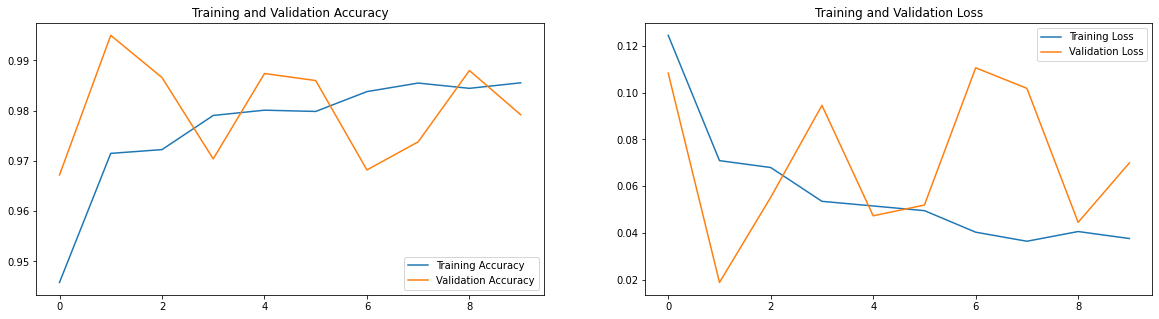

In [16]:
def show_loss_accuracy(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  plt.figure(figsize=(20, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

show_loss_accuracy(history)

# Saving the model

In [18]:
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
